## Import

In [1]:
# !pip install cv2
# !pip install moviepy
# !pip install mediapipe
# !pip install config
import cv2
import mediapipe as mp
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns  
from mpl_toolkits.mplot3d import Axes3D # 3D 시각화
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

#f_detector import
from imutils.video import VideoStream
import f_detector #만든 detector 라이브러리 
import imutils 

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

## 사용 알고리즘 및 함수툴 정의

In [2]:
## 얼굴 외곽 마스크 생성 방법
def face_outline_masking(results, landmark_dict, image):
    # 얼굴 외곽 정의한 것 가지고 얼굴 외곽 좌표 추출
    face_outline_coords = [
        (int(results.multi_face_landmarks[0].landmark[i].x * image.shape[1]),
        int(results.multi_face_landmarks[0].landmark[i].y * image.shape[0]))
        for i in landmark_dict['Outline_face']] 

    # 얼굴 외곽 마스크 생성
    mask = np.zeros_like(image)
    
    # 얼굴 부분을 빨간색으로 만들기
    cv2.fillPoly(mask, [np.array(face_outline_coords, dtype=np.int32)], (0, 0, 255))  # R : BGR 순서
    # cv2.fillPoly(mask, [np.array(face_outline_coords, dtype=np.int32)], (0, 255, 0))  # G : BGR 순서
    # cv2.fillPoly(mask, [np.array(face_outline_coords, dtype=np.int32)], (255, 0, 0))  # B : BGR 순서
    
    # 얼굴 마스크 적용
    masked_face = cv2.bitwise_and(image, mask)
    # 원본 영상에 얼굴 마스크 덧씌우기
    masked_image = cv2.addWeighted(image, 1, masked_face, 0.5, 0.1)  
    # 얼굴 영역 좌표 구하기
    x, y, w, h = cv2.boundingRect(np.array(face_outline_coords, dtype=np.int32))
    # 얼굴 내부 부분에 박스 그리기
    cv2.rectangle(masked_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # 얼굴에 bounding box 이름 추가
    text_size = cv2.getTextSize('Face', cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5, 1)[0]
    cv2.putText(masked_image, 'Face', (x + (w - text_size[0]) // 2, y + h + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    # 얼굴 마스크 적용
    masked_face = cv2.bitwise_and(masked_image, mask)
    # 원본 영상에 얼굴 마스크 덧씌우기
    masked_image = cv2.addWeighted(masked_image, 1, masked_face, 0.8, 0.1)
    return masked_face, masked_image, x,y, x+w, y+h, 


## hanging_cnt_v1 : z-score normal 후 부호를 이용해서 머리흔들림이 심한 프레임에 대해서 부호로 머리흔들림 스코어링 선정 -> 잘안될떄가 있다.
def hanging_cnt_v1(hanging_frame):
    #움직임에 대한 변화량을 z_score_normalization 함
    movement_array = z_score_norm(np.array(hanging_frame)[:,1])
    # print(f"sign change check for z_score_movement : {np.sign(movement_array)}")
    # movement_array = z_score_norm(hanging_frame[:,1])

    # 부호 변경 횟수를 카운트할 변수
    sign_change_count = 0

    # 이전 움직임의 부호 초기화
    previous_sign = np.sign(movement_array[0])

    # 배열을 순회하면서 부호 변경 횟수를 계산
    for i in range(1, len(movement_array)):
        current_sign = np.sign(movement_array[i])
        
        # 부호가 변경되면 카운트 증가
        if current_sign != previous_sign:
            # 다음 움직임이 다시 원래 부호로 돌아올 때만 카운트 증가
            if i + 1 < len(movement_array) and np.sign(movement_array[i + 1]) == previous_sign:
                # print(hanging_frame[])
                sign_change_count += 1
        
        previous_sign = current_sign

    print(f"v1_틱 증상  : {sign_change_count}")

## hanging_cnt_v2 : 프레임의 대한 범위를 지정해서 하나의 그룹으로 묶는다. 단점 : 프레임 범위인 threshold를 정해줘야함.
def hanging_cnt_v2(frames, threshold):
    # 그룹을 저장할 리스트
    groups = []

    # 현재 그룹에 속하는 프레임들을 저장할 리스트
    current_group = [frames[0]]

    # 프레임별로 그룹을 묶음
    for i in range(1, len(frames)):
        # 현재 프레임과 이전 프레임의 차이가 10프레임을 넘지 않으면 같은 그룹으로 묶음
        if frames[i] - frames[i-1] <= threshold:
            current_group.append(frames[i])
        else:
            # 차이가 10프레임을 넘으면 새로운 그룹 시작
            groups.append(current_group)
            current_group = [frames[i]]

    # 마지막 그룹 추가
    groups.append(current_group)
    # 결과 출력
    return len(groups)
    
def is_eye_closed(results, landmark_dict, image, threshold, tag):
    # 눈 가/세로 높이 정하기 위한 랜드마크 정의한 것 가지고 눈 좌표 추출
    # eye_blink_coords = np.array([
    #     (results.multi_face_landmarks[0].landmark[i].x,
    #     results.multi_face_landmarks[0].landmark[i].y)
    #     for i in landmark_dict[tag +'_eye_blink']])
    eye_blink_coords = np.array([
        (int(results.multi_face_landmarks[0].landmark[i].x * image.shape[1]),
        int(results.multi_face_landmarks[0].landmark[i].y * image.shape[0]))
        for i in landmark_dict[tag +'_eye_blink']])    
    
    # 눈 중심좌표 계산 
    eye_center = np.mean(eye_blink_coords, axis = 0)
    
    # 눈의 높이와 폭 계산
    eye_height = np.linalg.norm(eye_blink_coords[1] - eye_blink_coords[3])
    eye_width = np.linalg.norm(eye_blink_coords[0] - eye_blink_coords[2])

    # # 눈의 종횡비 계산
    aspect_ratio = eye_width / eye_height
    
    # # 눈이 감겨 있는지 여부를 판단
    # 임의의 임계값, 실험을 통해 조절
    if aspect_ratio > threshold:
        return 1, aspect_ratio
    else:
        return 0, aspect_ratio


#영역 부피 저장 함수
def save_area(area_array, tag, video_info):
    np.save(os.path.join('./data/np', str(video_info['path'].split('/')[-1].split('.')[0] + f'_{tag}')),area_array)

    
def z_score_norm(arr):
    # z-score normalization
    mean_val = np.mean(arr)
    std_dev = np.std(arr)
    return (arr - mean_val) / std_dev

# 전체 histogram 
def total_weight_score(hanging_score, unpair_blink_score, blink_score, w1, w2, w3):
    total = w1 * hanging_score + w2 * unpair_blink_score + w3 * blink_score 
    caused_tic_percent = total /(w1+w2+w3)
    # 틱 장애 위험도 
    return caused_tic_percent 

#머리를 흔드는 것에 대한 점수화 
def hanging_face_score(cnt, play_time, threshold):
    score = (cnt/play_time) * threshold
    if score < 0.5:
        return 0
    elif score > 0.5 and score < 1.0:
        return 0.2
    elif score > 1.0 and score < 1.5:
        return 0.4
    elif score > 1.5 and score < 2.0:
        return 0.6
    elif score > 2.0 and score < 2.5:
        return 0.8
    else:
        return 1.0

## 비대칭적으로 눈 감는 횟수를 점수화
def unpair_eye_blink_score(left_cnt, right_cnt, threshold):
    # 0~1 사이로 정규화
    abs_cnt = abs(left_cnt - right_cnt)
    if abs_cnt // threshold == 0: #기준치보다 미달일경우 0점 할당 
        return 0
    else: #0.2, 0.4, 0.6, 0.8, 1.0
        if abs_cnt // threshold == 1: 
            return 0.2
        elif abs_cnt // threshold == 2: 
            return 0.4
        elif abs_cnt // threshold == 3: 
            return 0.6
        elif abs_cnt // threshold == 4: 
            return 0.8
        else:
            return 1.0
        
## 평균적으로 1분에 10~15회 즉 5초에 1회정도 눈을 감는다를 정의 
def blink_equal_score(left_cnt, right_cnt, play_time, threshold):
    equal_cnt = ((left_cnt + right_cnt)/2) // play_time * threshold #threhold 시간당 1번 감는 평균 횟수 되는거임
    if equal_cnt < 1:
        return 0
    elif equal_cnt == 2:
        return 0.2
    elif equal_cnt == 3:
        return 0.4
    elif equal_cnt == 4:
        return 0.6
    elif equal_cnt == 5:
        return 0.8
    else:
        return 1.0


## Data load & Preprocessing

In [3]:
TEST_PATH = './data'
PATH = './data/backup/tic'
NON_TIC_PATH = './data/backup/non-tic'
SAVE_PATH = './result'
video_data = os.path.join(PATH, '40.mp4') 
# video_data = os.path.join(PATH, '28.mp4') 
# video_data = os.path.join(PATH, '21.mp4') 
# video_data = os.path.join(PATH, '34.mp4') 
# video_data = os.path.join(PATH, '37.mp4') 
# video_data = os.path.join(PATH, '26.mp4')

# 테스트 
# video_data = os.path.join(TEST_PATH, 'test1.mp4') 
# 강아지
# video_data = os.path.join(TEST_PATH, 'dog.mp4') 

## 일반인
# video_data = os.path.join(NON_TIC_PATH, '20.mp4') 

cap = cv2.VideoCapture(video_data) #<- video data  / streaming data -> cv2.VideoCapture(0)



## 불러온 비디오 파일 정보 출력
video_info = {
    'name' : video_data.split('/')[-1].split('.')[0],
    'path' : video_data,
    'fps' : cap.get(cv2.CAP_PROP_FPS),
    'total frame' : int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), # 프레임수
    'width' : int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), # 가로 길이
    'height' : int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), # 세로 길이
    "running_time('s)" : int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) // int(cap.get(cv2.CAP_PROP_FPS))
}
## 비디오 저장 객체 만들기
out = cv2.VideoWriter(
    os.path.join(SAVE_PATH, ('masked_' + video_data.split('/')[-1].split('.')[0]))+".mp4",
    cv2.VideoWriter_fourcc(*'DIVX'),
    video_info['fps'],
    (video_info['width'], video_info['height'])
    )


print(f"Video Information : {video_info}")


#여러 지점 좌표
landmark_dict = {
    #왼쪽눈
    'L_eye' : [33, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163, 7], #시계방향 9시부터 시작
    #오른쪽눈
    'R_eye' : [369, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374, 380, 381, 382], #시계방향 9시부터 시작
    #왼쪽 눈동자
    'L_iris' : [470, 471,469, 472, 468], #위에서부터 Up, Left, Right, Down, Center position
    #오른쪽 눈동자
    'R_iris' : [475, 476, 474, 477, 473],
    #왼쪽 눈썹
    'L_eyebrow' : [70, 63, 105, 66, 107, 55, 65, 52 ,53, 46], #시계방향 9시부터 시작
    #오른쪽 눈섭
    'R_eyebrow' : [336, 296, 334, 293, 300, 276, 283, 282, 295 ,285], #시계방향 9시부터 시작
    #윗 입술
    'Up_lips' : [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 391, 308, 415, 310, 311, 312, 13, 82, 81, 80, 191, 78],#시계방향 9시부터 시작
    #아랫 입술
    'Down_lips' : [61, 78, 95, 88, 178, 87, 14, 317, 402, 318, 324, 308, 391, 375, 321, 405, 314, 17, 84, 181, 91, 146],#시계방향 9시부터 시작
    #입술 안
    'Inner_lips' : [78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308, 324, 318, 402, 317, 14, 87, 178, 88, 95],#시계방향 9시부터 시작
    #얼굴외곽
    'Outline_face' : 
        [234, 127, 162, 21, 54, 103, 67, 109, 10, 338, 297, 332, 284,
         251, 389, 356, 454, 323, 361, 288, 397, 365, 379, 378, 400,
         377, 152, 148, 176, 149, 150, 136, 172, 58, 132, 93],
    'L_eye_blink' : [33, 159, 133, 145],
    'R_eye_blink' : [362, 386, 263, 374], 
}

Video Information : {'name': '40', 'path': './data/backup/tic/40.mp4', 'fps': 24.0, 'total frame': 97, 'width': 1280, 'height': 720, "running_time('s)": 4}


## Main Act Code

In [7]:
### Configure Varaible 
## Video Setting
cap = cv2.VideoCapture(video_data) # video load 
drawing_spec = mp_drawing.DrawingSpec(thickness = 3, circle_radius = 3)

## 얼굴 랜드마크 검출 객체
landmark = []

## fps 탐지
import time
start_time = time.time()

## 머리 흔들기 객체
hanging_cnt = 0
hanging_threshold = 0.05
hanging_frame = []

## 눈 감기는 횟수 객체 
left_eye_closed_cnt = 0
right_eye_closed_cnt = 0
eye_blink_threshold = 10 # 눈 감길때 논의 종횡비 계산 threshold
blink_frame = []


### Video Action Code
with mp_face_mesh.FaceMesh(  
        max_num_faces=3, #최대 검출 얼굴 개수
        refine_landmarks=True, # 눈과 입술 주변 랜드마크 정교하게 검출시 True
        min_detection_confidence=0.5, #최소 Detection 기준
        min_tracking_confidence=0.5, #최소 traicking 기준
        static_image_mode=True) as face_mesh:
    frame = 1
    while cap.isOpened():
        # print(f"frame : {frame} frame")
        
        ret, image = cap.read()
        # 현재 시간과 이전 시간과의 경과 시간 계산
        elapse_time = time.time() - start_time
        
        # 현재 fps 계산
        fps = 1 / elapse_time
        
        # if not ret:
        #     print("웹캠을 찾을 수 없습니다.")
        #     # 비디오 파일의 경우 'continue'를 사용하시고, 웹캠에 경우에는 'break'를 사용하세요
        #     # continue
        #     break
        if not ret: #영상 더 가지고 올게 없으면 끝내기
            cv2.destroyAllWindows()
            cv2.waitKey(1)
            break
        else: #영상 진행 중일때 
            # 필요에 따라 성능 향상을 위해 이미지 작성을 불가능함으로 기본 설정합니다.
            image.flags.writeable = False
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = face_mesh.process(image)

            # 이미지 위에 얼굴 그물망 주석을 그립니다.
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            if results.multi_face_landmarks:
                for face_landmarks in results.multi_face_landmarks:
                    mp_drawing.draw_landmarks(
                        image=image,
                        landmark_list=face_landmarks,
                        connections=mp_face_mesh.FACEMESH_TESSELATION,
                        landmark_drawing_spec=None,
                        connection_drawing_spec=mp_drawing_styles
                        .get_default_face_mesh_tesselation_style())
                    mp_drawing.draw_landmarks(
                        image=image,
                        landmark_list=face_landmarks,
                        connections=mp_face_mesh.FACEMESH_CONTOURS,
                        landmark_drawing_spec=None,
                        connection_drawing_spec=mp_drawing_styles
                        .get_default_face_mesh_contours_style())
                    mp_drawing.draw_landmarks(
                        image=image,
                        landmark_list=face_landmarks,
                        connections=mp_face_mesh.FACEMESH_IRISES,
                        landmark_drawing_spec=None,
                        connection_drawing_spec=mp_drawing_styles
                        .get_default_face_mesh_iris_connections_style())
                    
                    ## masking 및 박스 플랏 이미지
                    masked_face, masked_image, x,y, x_w, y_h,  = face_outline_masking(results, landmark_dict, image)
                    
                    ## 눈 깜빡임 횟수 정의is_eye_closed
                    l_cnt, left_eye_landmarks = is_eye_closed(results, landmark_dict, image, eye_blink_threshold, tag = 'L')    
                    r_cnt, right_eye_landmarks = is_eye_closed(results, landmark_dict, image, eye_blink_threshold, tag = 'R')    
                    # 프레임 별로 저장
                    blink_frame.append([frame, left_eye_landmarks, right_eye_landmarks])
                    # 눈 깜빡임 횟수 추가
                    left_eye_closed_cnt += l_cnt
                    right_eye_closed_cnt += r_cnt

                    ## 프레임 구간별(default : 10fps) 얼굴 움직임 변화량 측정
                    # 현재 랜드마크 좌표
                    current_landmark = np.array([(point.x, point.y, point.z) for point in face_landmarks.landmark])
                    if frame == 1: #첫 번쨰 프레임일떄는
                        # 현재 랜드마크를 이전 랜드마크로만 저장
                        previous_landmark = current_landmark
                        tag_detected = False
                        tag = 0
                        distances = 0
                        continue
                    else:
                        # 모든 랜드마크의 변화량 계산
                        distances = np.linalg.norm(np.abs(current_landmark - previous_landmark), axis=1)
                        # 평균변화량 출력 : Heuristic threshold Setting 0.05  
                        if np.mean(distances) > hanging_threshold:
                            # print(f"Landmark Movement|frame :{np.mean(distances)}|{frame}")
                            hanging_frame.append([frame, np.mean(distances)])
                            tag_detected = True 
                            tag += 1
                        else:
                            tag_detected = False
                        # 현재 랜드마크를 이전 랜드마크로 저장
                        previous_landmark = current_landmark



            try:
                landmark.append(results.multi_face_landmarks)        
            except TypeError:
                continue
            
            ## FPS 표시
            cv2.putText(masked_image, f"FPS : {fps:.2f}", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
            ## frame 표시
            cv2.putText(masked_image, f"Frame : {frame}", (0, video_info['height']-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA) 
            ## 초 표시
            second_record = (frame / video_info['fps'])
            cv2.putText(masked_image, f"Play time : {second_record:.2f}sec", (video_info['width']-180, video_info['height']-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA) 
                        
            ## 눈이 감겼을 때 메시지 추가
            if r_cnt == 1: #눈 감겼을때 cnt = 1로 지정한 것으로 판단 x,y, x_w, y_h
                cv2.putText(masked_image, f"R_Blink : {left_eye_landmarks/10:.2f}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                # cv2.putText(masked_image, f"Blink {right_eye_closed_cnt}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
            else:
                cv2.putText(masked_image, f"R_Blink : {left_eye_landmarks/10:.2f}", (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
                # cv2.putText(masked_image, f"Blink : {right_eye_closed_cnt}", (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)

            if l_cnt == 1: #눈 감겼을때 cnt = 1로 지정한 것으로 판단
                cv2.putText(masked_image, f"L_Blink : {right_eye_landmarks/10:.2f}", (x_w, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                # cv2.putText(masked_image, f"Blink : {left_eye_closed_cnt}", (x_w, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
            else:
                cv2.putText(masked_image, f"L_Blink : {right_eye_landmarks/10:.2f}", (x_w, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
                # cv2.putText(masked_image, f"Blink : {left_eye_closed_cnt}", (x_w, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
            
            
            ## 얼굴 큰 흔들림 태그 감지 및 횟수 메시지 추가
            if tag_detected:
                cv2.putText(masked_image, "Head hadly shake detect!!", ((x+x_w)//2, y-30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2, cv2.LINE_AA)
                cv2.putText(masked_image, f"Head Hanging Count : {tag} | {np.mean(distances*10):.2f}", (video_info['width']-250, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA) 
            else:
                cv2.putText(masked_image, f"Head Hanging Count : {tag} | {np.mean(distances*10):.2f}", (video_info['width']-250, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA) 
            

            
            # 보기 편하게 이미지를 좌우 반전합니다.
            # edge_image = cv2.Canny(image, 100, 255)
            
            # cv2.imshow('MediaPipe Face Mesh(Puleugo)', image)
            cv2.imshow('MediaPipe Face Mesh(Puleugo)', masked_image)
            # cv2.imshow('MediaPipe Face Mesh(Puleugo)', frame_image)
            
            # 현재 시간 갱신
            start_time = time.time()
            
            ## 동영상 파일 저장
            out.write(masked_image)
            
            # Esc 누르면 영상 종료
            if cv2.waitKey(5) & 0xFF == 27:
                #맥에서 opencv 안닫힐때 꿀팁
                cv2.destroyAllWindows()
                cv2.waitKey(1)
                cv2.waitKey(1)
                cv2.waitKey(1)
                cv2.waitKey(1)
                break
        frame += 1
cap.release()
out.release()
### Algorithms Result
# hanging_cnt_v1(hanging_frame)
hanging_cnt = hanging_cnt_v2(np.array(hanging_frame)[:,0], threshold= video_info['fps'])
print(f"v2_틱 증상 횟수 : {hanging_cnt}번")
print(f"left_eye_blink_cnt : {left_eye_closed_cnt}회")
print(f"right_eye_blink_cnt : {right_eye_closed_cnt}회\n")


### Scoring System
hanging_score = hanging_face_score(hanging_cnt, second_record, threshold = 5) #5초당 평균 머리 흔들기 횟수 점수화
print(f"평균 머리 흔들기 횟수 점수 : {hanging_score}")
unpair_blink_score = unpair_eye_blink_score(left_eye_closed_cnt, right_eye_closed_cnt, threshold = 3)
print(f"비대칭 눈감기 점수 : {unpair_blink_score}")
blink_score = blink_equal_score(left_eye_closed_cnt, right_eye_closed_cnt, second_record, threshold = 5)
print(f"평균 눈 감는 횟수 점수 : {blink_score}")

### Total Score
w1 = 0.6 #머리흔들기 가중치
w2 = 0.3 #짝눈 가충치
w3 = 0.1 #눈감기 가중치
total_score = total_weight_score(hanging_score, unpair_blink_score, blink_score, w1, w2, w3)
print(f"틱 장애 위험도 : {total_score*100:.2f}점 (0~100) *w1 : {w1}, w2 : {w2}, w3 : {w3}")
### Check

v2_틱 증상 횟수 : 2번
left_eye_blink_cnt : 10회
right_eye_blink_cnt : 4회

평균 머리 흔들기 횟수 점수 : 0.8
비대칭 눈감기 점수 : 0.4
평균 눈 감는 횟수 점수 : 0.8
틱 장애 위험도 : 68.00점 (0~100) *w1 : 0.6, w2 : 0.3, w3 : 0.1


# Analysis

## Feature Analysis
* 세팅
* 랜드마크 분석 x,y,z좌표 제대로 나왔는지 확인
* 틱 관련 중요 부위 영역(넓이) 분석 * x,y만 이용 
* 짝눈 분석 : 두 눈의 영역 차이 변화도를 이용한 점수화 threshold 정하기
* 눈 감는 횟수 분석 : 두 눈의 감는 횟수를 평균적으로 구하여  점수화 threshold 정하기
* 머리 흔들림 차이 분석 : 흔들림에 대한 프레임별 분석하여 점수화 threshold 정하기

In [13]:
#랜드마크 처리 
### landmakr[frame].multi_face_landmarks[person_cnt].landamrk[landmark number(1~478)]
# print(frame_len, person_len, landmark_len)
def save_np(landmark, video_info):
    frame_len = len(landmark) 
    person_len = len(landmark[0]) #사람 몇명인지
    landmark_len = len(landmark[0][0].landmark)
    landmark_arr = np.zeros((frame_len, person_len, landmark_len, 3))
    # Landmark Data preprocessing
    for frame_idx in range(frame_len):
        try:
            person_len = len(landmark[frame_idx]) #사람 몇명인지
        except:
            continue
        for person_idx in range(person_len):
            try:
                landmark_len = len(landmark[frame_idx][person_idx].landmark)
                for landmark_idx in range(landmark_len):
                    x,y,z, _= map(str, str(landmark[frame_idx][person_idx].landmark[landmark_idx]).split('\n'))
                    
                    landmark_arr[frame_idx, person_idx, landmark_idx] = x.split(' ')[-1],y.split(' ')[-1],z.split(' ')[-1] 
                    # print(landmark_arr)
            except:
                continue

    np.save(os.path.join('./data/np', video_info['name']), landmark_arr)
    print(f"Saved numpy file : {os.path.join('./data/np', video_info['name'])}")
    print(f"Arr shpae : {landmark_arr.shape} : (frame, person_num, landmark idx, postion(x,y,z))") #-> (Frame, Person Num, Landmark_index, position(x,y,z))    
    return landmark_arr
# print(landmark[0])

## 랜드마크 프레임별 저장 함수 실행
landmark_arr = save_np(landmark, video_info)

Saved numpy file : ./data/np/34
Arr shpae : (210, 1, 478, 3) : (frame, person_num, landmark idx, postion(x,y,z))


array([ 0.46407235,  0.49638525, -0.05645602])

### 랜드마크 분석 : x,y,z 좌표 제대로 나왔는지?

#### 랜드마크 분석 1 : 랜드마크 별 위치 인덱스 확인 

landamark_arr shape : (210, 1, 478, 3)


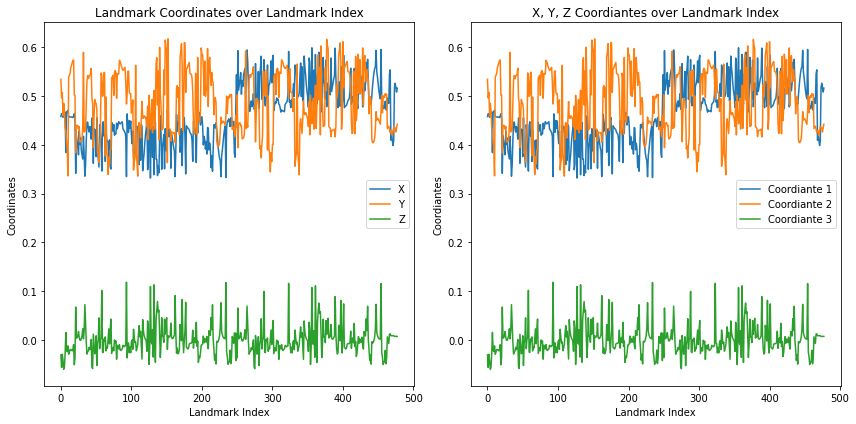

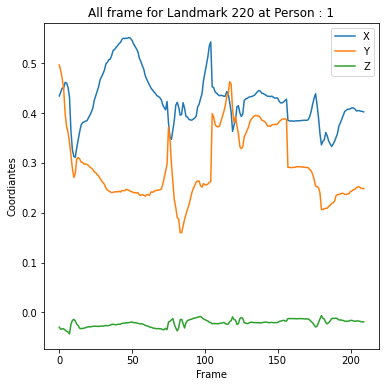

In [16]:
# landmark arr : (frame_index, person_index, landmark_index, (x,y,z))
# landmark_arr = np.load('./data/np/test2.npy')
landmark_arr = np.load(f'./data/np/'+video_info['name']+'.npy')
def landmark_analysis_plot(landmark_arr):
    print(f"landamark_arr shape : {landmark_arr.shape}")
    frame_idx, person_idx = 0, 0 #frame 별, 사람 별
    landmarks_person_frame = landmark_arr[frame_idx, person_idx] #frame별 x,y,z 좌표 변화
    num_landmarks = landmarks_person_frame.shape[0]

    #랜드마크 수의 변화를 나타내는 그래프
    plt.figure(figsize = (12,6))
    plt.subplot(121)
    plt.plot(range(num_landmarks), landmarks_person_frame[:, 0], label='X')
    plt.plot(range(num_landmarks), landmarks_person_frame[:, 1], label='Y')
    plt.plot(range(num_landmarks), landmarks_person_frame[:, 2], label='Z')
    plt.title('Landmark Coordinates over Landmark Index')
    plt.xlabel('Landmark Index')
    plt.ylabel('Coordinates')
    plt.legend()

    # x, y, z변화를 나타내는 그래프
    plt.subplot(122)
    for i in range(3): #landmark index별 x,y,z의 
        plt.plot(range(num_landmarks), landmarks_person_frame[:, i], label=f'Coordiante {i+1}')
    plt.title('X, Y, Z Coordiantes over Landmark Index')
    plt.xlabel('Landmark Index')
    plt.ylabel('Coordiantes')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    ## 전체 프레임 별 사람 별 특정 랜드마크에 대한 x,y,z 변화도 
    landmark_idx= 219 #220번쨰 랜드마크 

    plt.figure(figsize=(int(f"{landmark_arr.shape[1]*6}"),6))
    for person_idx in range(landmark_arr.shape[1]):
        plt.subplot(1, landmark_arr.shape[1], person_idx+1)
        x_coordiantes = landmark_arr[:, person_idx, landmark_idx, 0]
        y_coordiantes = landmark_arr[:, person_idx, landmark_idx, 1]
        z_coordiantes = landmark_arr[:, person_idx, landmark_idx, 2]
        plt.plot(range(landmark_arr.shape[0]), x_coordiantes, label=f'X')
        plt.plot(range(landmark_arr.shape[0]), y_coordiantes, label=f'Y')
        plt.plot(range(landmark_arr.shape[0]), z_coordiantes, label=f'Z')
        plt.title(f'All frame for Landmark {landmark_idx+1} at Person : {person_idx+1}')
        plt.xlabel('Frame')
        plt.ylabel(f'Coordiantes')
        plt.legend()
    plt.show()
    
            
landmark_analysis_plot(landmark_arr)
    """plot 요약
    Args:
        landmark_arr (array): 478개의 landmark에 대한 위치좌표를 다 보여준다.
        x (float32): position x 좌표 index (:,:,:,0)
        y (float32): position x 좌표 index (:,:,:,1)
        z (float32): position x 좌표 index (:,:,:,2)
        첫번쨰 플랏 그림은 landmark 별로 x,y,z의 값들을 파악할 수 있음 -> 위치 파악가능
        두번째 그림은 프레임별 landmark 220번의 변화도를 파악할 수 있음 
    """

#### 랜드마크 분석 2 : 위치별 인덱스 3D로 확인

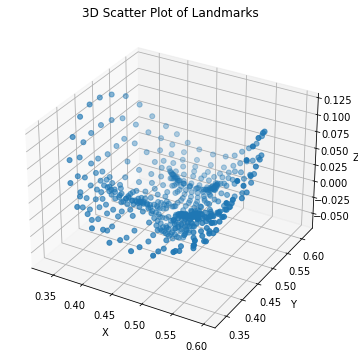

In [50]:
# 랜드마크 arr to df
landmark_arr = np.load(f'./data/np/'+video_info['name']+'.npy')
reshaped_arr = landmark_arr[0,0].reshape(-1,3)
landmark_df = pd.DataFrame(reshaped_arr, columns=['X', 'Y', 'Z'])
landmark_df
# 3D 산점도 그리기
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(landmark_df['X'], landmark_df['Y'], landmark_df['Z'], s=25, )  # s는 점의 크기를 나타냅니다.

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Scatter Plot of Landmarks')

plt.show()

In [18]:
# landmark_arr = np.load('./data/np/test2.npy')
landmark_arr = np.load(f'./data/np/'+video_info['name']+'.npy')

(210, 1, 478, 3)


### 틱 관련 중요 부위 영역 분석

In [ ]:
# 삼각형 메쉬 데이터 면적 계산
def calculate_triangle_area(vertices):
    # 세점 A,B,C
    A, B, C = vertices
    
    #벡터 AB, AC 계산
    AB = B - A
    AC = C - A 
    
    #외적 계산
    cross_product = np.cross(AB, AC) 
    
    # 삼각형 넓이 계산
    area = 0.5 * np.linalg.norm(cross_product)
    
    return area
#부위의 모든 랜드마크 면적 계산 누적 함수 
def cal_area(landmark, landmark_dict, tag):
    # 각 점 x,y 좌표 추출
    try:
        iris_landmark = landmark[:, :, landmark_dict[tag], :]        
        # print(f' iris_landmark shape : {iris_landmark.shape}')
        # 각 프레임별 사람별 면적 저장하기 
        area_fr_per = np.zeros((iris_landmark.shape[0], iris_landmark.shape[1]))
        # 각프레임별 루프
        for frame_idx in range(iris_landmark.shape[0]):
            #각 사람별 루프
            for person_idx in range(iris_landmark.shape[1]):
                # 각 랜드마크별로 루프
                mesh_vetrices = iris_landmark[frame_idx, person_idx, :, : ]
                total_area = 0. 
                for landmark_idx in range(1, iris_landmark.shape[2]-1):
                    vetrices = np.array([
                        iris_landmark[frame_idx, person_idx, 0, :],
                        iris_landmark[frame_idx, person_idx, landmark_idx, :],
                        iris_landmark[frame_idx, person_idx, landmark_idx+1, :],
                        ])
                    total_area += calculate_triangle_area(vetrices)
                area_fr_per[frame_idx, person_idx] = total_area
                      
    except:
        print('Error')

    # print(f"{tag} area shape : {area_fr_per.shape}")

    return area_fr_per

L_eye_area = cal_area(landmark_arr, landmark_dict, 'L_eye')
R_eye_area = cal_area(landmark_arr, landmark_dict, 'R_eye')
L_iris_area = cal_area(landmark_arr, landmark_dict, 'L_iris')
R_iris_area = cal_area(landmark_arr, landmark_dict, 'R_iris')
L_eyebrow_area = cal_area(landmark_arr, landmark_dict, 'L_eyebrow')
R_eyebrow_area = cal_area(landmark_arr, landmark_dict, 'R_eyebrow')
Up_lips_area = cal_area(landmark_arr, landmark_dict, 'Up_lips')
Down_lips_area = cal_area(landmark_arr, landmark_dict, 'Down_lips')
Inner_lips_area = cal_area(landmark_arr, landmark_dict, 'Inner_lips')

area_dict = {
    'L_eye_area' : L_eye_area,
    'R_eye_area' : R_eye_area,
    'L_iris_area' : L_iris_area,
    'R_iris_area' : R_iris_area,
    'L_eyebrow_area' : L_eyebrow_area,
    'R_eyebrow_area' : R_eyebrow_area,
    'Up_lips_area' : Up_lips_area,
    'Down_lips_area' : Down_lips_area,
    'Inner_lips_area' : Inner_lips_area
}

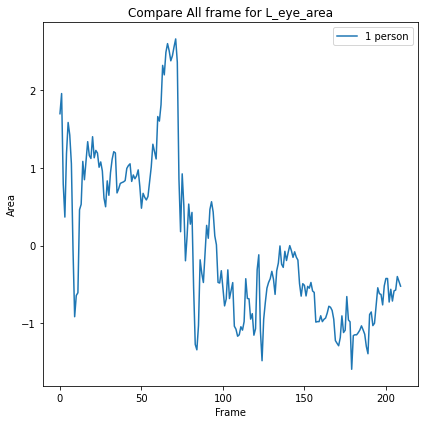

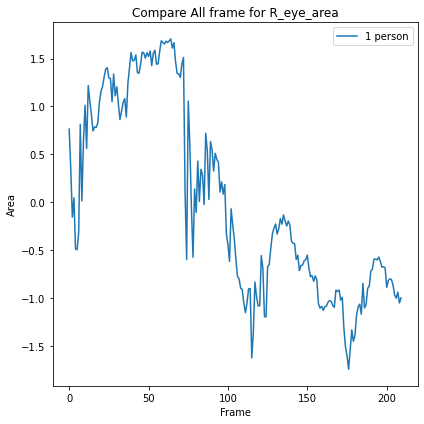

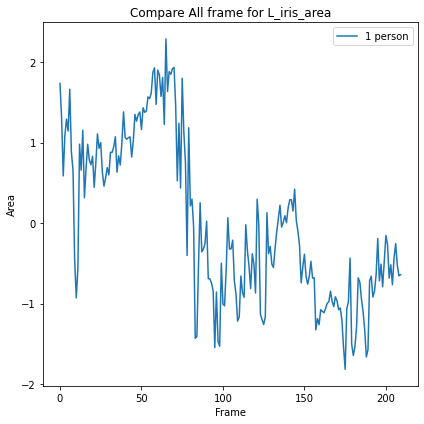

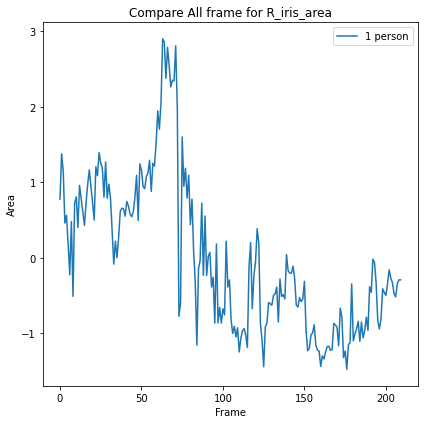

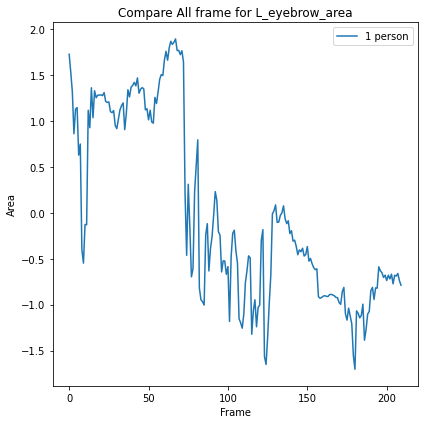

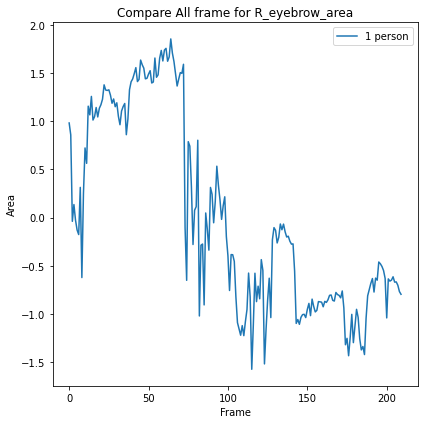

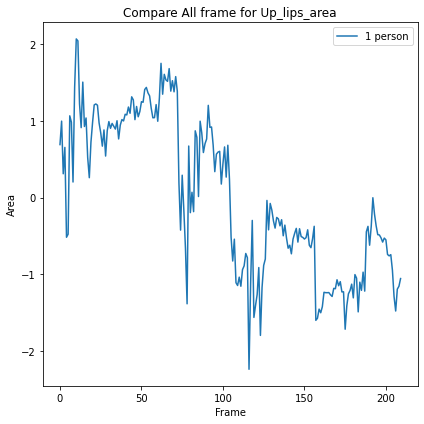

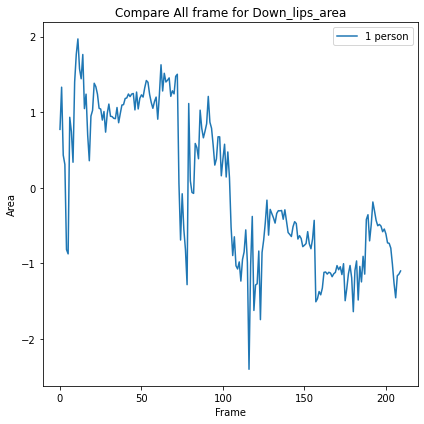

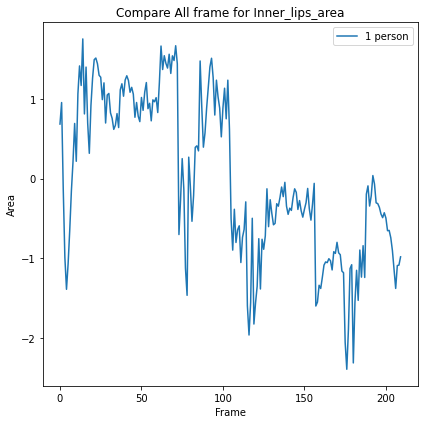

In [42]:
# 프레임별 면적 분석
def area_analysis(landmark_arr, tag):
    plt.figure(figsize=(int(f"{landmark_arr.shape[1]*6}"),6))
    # 사람별로 프레임별 면적 계산
    for person_idx in range(landmark_arr.shape[1]):
        plt.subplot(1, landmark_arr.shape[1], person_idx+1)
        plt.plot(range(landmark_arr.shape[0]), landmark_arr[:,person_idx], label=f'{person_idx+1} person')
        plt.title(f'Compare All frame for {tag}')
        plt.xlabel('Frame')
        plt.ylabel(f'Area')
        plt.legend()
        plt.tight_layout()
    plt.savefig(os.path.join('./analysis', (video_info['name']+f"_{person_idx+1}p_{tag}.png")), bbox_inches = 'tight')
    plt.show()
area_dict = {
    'L_eye_area' : z_score_norm(L_eye_area),
    'R_eye_area' : z_score_norm(R_eye_area),
    'L_iris_area' : z_score_norm(L_iris_area),
    'R_iris_area' : z_score_norm(R_iris_area),
    'L_eyebrow_area' : z_score_norm(L_eyebrow_area),
    'R_eyebrow_area' : z_score_norm(R_eyebrow_area),
    'Up_lips_area' : z_score_norm(Up_lips_area),
    'Down_lips_area' : z_score_norm(Down_lips_area),
    'Inner_lips_area' : z_score_norm(Inner_lips_area)
}
## 영역 분석 
for key, value in area_dict.items():
    save_area(value, key, video_info)
    area_analysis(value, key)


### 짝 눈 분석 : 두눈의 차이 변화도를 이용한 threshold 정하기

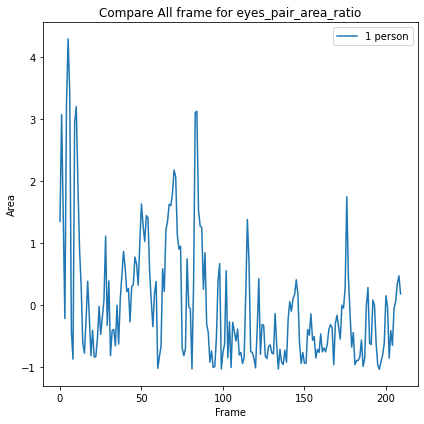

In [43]:
## 짝눈 분석 : 변화도가 큰 frame 구간 추출하기
eyes_pair_area_ratio = np.array([])
for i in range(len(area_dict['L_eye_area'])):
    eyes_pair_area_ratio = np.abs(area_dict['L_eye_area'] - area_dict['R_eye_area'])
    
area_analysis(z_score_norm(eyes_pair_area_ratio), 'eyes_pair_area_ratio')
# -> 변화도가 크다는 것은 즉 짝짜기로 눈을 감는 것이 크다는 것을 말한다. 

### Eye Blink 분석 : 눈 감기 분석

#### 눈 감기 분석 1 : L_eye_area의 변화량 계산 -> 눈을 감는 것에 대한 평균 점수 threshold를 정하기 위해 사용

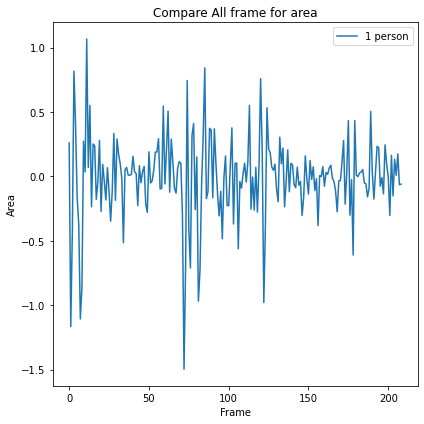

1초 - 2초: 평균 L_eye_area 변화량 = [-0.028699]
2초 - 3초: 평균 L_eye_area 변화량 = [-0.00140521]
3초 - 4초: 평균 L_eye_area 변화량 = [0.0576841]
4초 - 5초: 평균 L_eye_area 변화량 = [-0.0978692]
5초 - 6초: 평균 L_eye_area 변화량 = [-0.04499583]
6초 - 7초: 평균 L_eye_area 변화량 = [0.0412536]
7초 - 8초: 평균 L_eye_area 변화량 = [-0.0361855]
8초 - 9초: 평균 L_eye_area 변화량 = [-0.0033989]


In [45]:
## L_eye_area의 변화량 계산 -> 눈을 감는 것에 대한 threshold를 정하기 위해 사용
area = z_score_norm(area_dict['L_eye_area'])

fps = 24
num_frames = len(area)
seconds = num_frames / fps 
delta_L_eye_area = np.array([area[i+1] - area[i] for i in range(num_frames-1)])
area_analysis(delta_L_eye_area, 'area')

# 초당 평균 변화량 계산
average_change_per_second = sum(delta_L_eye_area) / seconds

# 초 범위로 평균 변화량 계산
interval_seconds = 1  # 초 범위
num_intervals = int(seconds / interval_seconds)

average_change_by_interval = [sum(delta_L_eye_area[i*fps:(i+1)*fps]) / fps for i in range(num_intervals)]

# 결과 출력
for i, avg_change in enumerate(average_change_by_interval):
    print(f"{i+1}초 - {i+2}초: 평균 L_eye_area 변화량 = {avg_change}")




#### 눈 감기 분석 2 : 눈을 감는 것에 데한 종횡비 threshold를 정하기 위한 분석


(211, 2)
211
[ 4.45252737  4.9429174   7.67112468  7.21110255  6.74124947  6.
  5.90931468  7.73602959  3.27448045  4.70106371  5.1747249   3.83482494
  7.3006849   8.60232527  8.43800924 18.78829423  5.12640225  6.15223537
  5.86941224  5.          3.87620949  4.37074917  4.51816258  5.4405882
  4.52769257  5.84103134  5.84103134  7.3006849   7.3006849   5.820855
  4.51067111  4.51493249  3.78474891  3.9455757   4.70678724  5.820855
  4.40454311  3.51583718  4.1370744   3.51583718  3.51583718  3.53553391
  3.37062474  2.88910692  2.77378398  3.39934634  3.39934634  3.23608131
  2.45586034  2.80669753  3.11359028  3.32080981  3.98497177  3.32080981
  3.32080981  3.27448045  2.98294472  3.1200471   3.08386188  3.6502499
  3.3624578   3.33503358  3.12311482  2.76960858  3.71703195  3.35123399
  3.47518677  3.96232255  3.82099463  3.85589478  3.68594722  4.04222991
  4.41021541  5.18844871  5.83095189  2.95596091  2.50860588  2.85287379
  2.66879167  3.62051213  6.93375245  9.51971638  7.

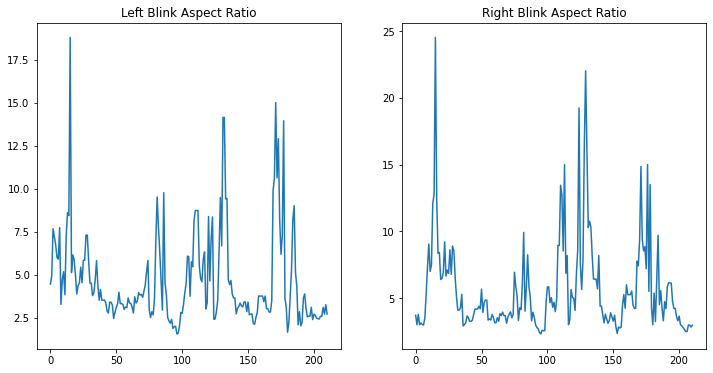

In [46]:
## 눈을 감는 것에 데한 종횡비 threshold를 정하기 위한 분석
def blink_z_score_norm(arr):
    # z-score normalization
    left_mean_val = np.mean(arr[:,0])
    left_std_dev = np.std(arr)
    
    right_mean_val = np.mean(arr[:,1])
    right_std_dev = np.std(arr)
    return (arr[:,0] - left_mean_val) / left_std_dev, (arr[:,1] - right_mean_val) / right_std_dev

## 눈 감는 것에 대한 종횡비 비교 분석
# left_right_norm = blink_arr[:,1:]
blink_arr = np.array(blink_frame)
# left_norm, right_norm = blink_z_score_norm(blink_arr[:,1:])
left_norm, right_norm = blink_arr[:,1], blink_arr[:,2]
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(range(len(left_norm)), left_norm)
plt.title('Left Blink Aspect Ratio')
plt.subplot(122)
plt.plot(range(len(left_norm)), right_norm)
plt.title('Right Blink Aspect Ratio')
# plt.legend()
plt.show()

### 머리 흔들림 차이 분석 : 흔들림에 대한 프레임별 분석하여 점수화 threshold 정하기

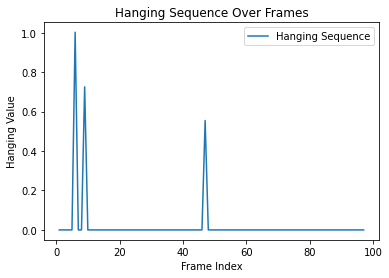

'\n    hanging threshold 정하기 -> 0.05 이상이면 hardly hanging 으로 판단\n'

In [161]:
# frame 별 hanging seq 분석
hanging_array = np.zeros((video_info['total frame'],1))
hanging_array.shape

# hanging_array[np.array(hanging_frame[:,0]).astype(int)] = np.array(hanging_frame)[:,1]
for idx, point in enumerate(np.array(hanging_frame)[:,0].astype(int)):
    hanging_array[point] = hanging_frame[idx][1]*10

# hanging_array를 플로팅
plt.plot(range(1, video_info['total frame']+1), hanging_array, label='Hanging Sequence')
plt.xlabel('Frame Index')
plt.ylabel('Hanging Value')
plt.title('Hanging Sequence Over Frames')
plt.legend()
plt.show()

"""
    hanging threshold 정하기 -> 0.05 이상이면 hardly hanging 으로 판단
"""

## Tic/Non-tic 비교분석 (진행중) Tic/Non-Tic Feature 추출 및 분석
* 일부(2,2) or 전체 (2,2) → 먼저 일부만 해서 분석하자
* 머리 흔들림 차이에 대한 Tic / Non-Tic 분석
* 평균 정해진 시간에 따른 눈 감기 횟수 분석
* 짝눈에 대한 횟수 분석 Tic

### 일부(2,2) or 전체 (2,2) → 먼저 일부만 해서 분석하자

### 머리 흔들림 차이에 대한 Tic / Non-Tic 분석

### 평균 정해진 시간에 따른 눈 감기 횟수 분석

### 짝눈에 대한 횟수 분석 Tic